# LTSM - Stock price prediction

In this notebook I am trying to predict next day close prices using a neural net containg LTSM cells. 
The reasoming behind the model choice is that we are dealinfg with time series data so an RNN structure is desired. LTSM cells are used as they help deal with the vanashing gradient problem seen in RNNs. 

## Get the data 

In [1]:
import numpy as np
import pandas_datareader as pdr

In [2]:
df = pdr.get_data_yahoo('NVDA')

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-05-30,36.572498,35.762501,35.924999,36.217499,98965200.0,35.823048
2017-05-31,36.750000,35.512501,36.672501,36.087502,88731600.0,35.694462
2017-06-01,36.257500,35.630001,36.247501,36.090000,50334000.0,35.696938
2017-06-02,36.325001,35.849998,36.060001,35.910000,48745600.0,35.518906
2017-06-05,37.132500,35.627499,35.744999,37.002499,81737600.0,36.599499


In [4]:
X = df.iloc[:, [0, 1, 2, 4, 5]]
y = df.iloc[:, 3:4] 

## Data preprocesing 

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [6]:
#300 for training

X_train = X_ss[700:1000, :]
X_test = X_ss[1000:1200, :]

y_train = y_mm[701:1001, :] # shift over by 1 for next day 
y_test = y_mm[1001:1201, :] 

I have scaled the X data as it's attributes are on a different scale e.g. volume and open. I have also 
scaled the y data to keep the magnitude of the loses under control.

In [7]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (300, 5) (300, 1)
Testing Shape (200, 5) (200, 1)


In [8]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [9]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [10]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [11]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 


Training Shape torch.Size([300, 1, 5]) torch.Size([300, 1])
Testing Shape torch.Size([200, 1, 5]) torch.Size([200, 1])


## Defining the model

In [13]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [26]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 100 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [27]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 


In [28]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [29]:
torch.manual_seed(16) # set seed to get reproducibility of results 

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.10153
Epoch: 100, loss: 0.00022
Epoch: 200, loss: 0.00013
Epoch: 300, loss: 0.00013
Epoch: 400, loss: 0.00012
Epoch: 500, loss: 0.00011
Epoch: 600, loss: 0.00011
Epoch: 700, loss: 0.00011
Epoch: 800, loss: 0.00011
Epoch: 900, loss: 0.00011


In [30]:
with torch.no_grad():
    pred_y_test = lstm1.forward(X_test_tensors_final)
    pred_y_train = lstm1.forward(X_train_tensors_final)

In [31]:
pred_y_test = pred_y_test.data.numpy()
pred_y_train = pred_y_train.data.numpy()

In [32]:
real_y_test = y_test_tensors.data.numpy()
real_y_train = y_train_tensors.data.numpy()

In [33]:
test_MSE = np.sum(np.square(pred_y_test - real_y_test))
train_MSE = np.sum(np.square(pred_y_train - real_y_train))
print('The test MSE is:', test_MSE)
print('The train MSE is:', train_MSE)

The test MSE is: 0.4206023
The train MSE is: 0.032311074


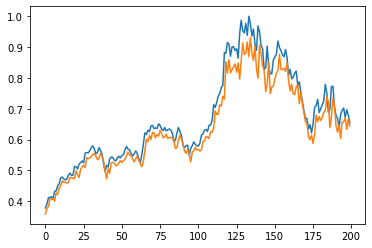

In [34]:
import matplotlib.pyplot as plt 

plt.plot(real_y_test)
plt.plot(pred_y_test)

In the above figure we can see that model preforms relativally well in the early days of the test set.
However, as time increases the real labels seem to diverge away from the predicted labels. This is beacause the model is making predictions from data that is 20, 40, or even 200 days old. Even though the model has been trained to optimise predictions on the current data. This makes it a poor predictor for lables that are much further ahead in time to the 'seen' train data. Therefore, to properly asses the accuarcy of a time depependent neural net, a new model containing all the data available up to that point in time must be trained to make an accurate prediction. So, if 200 testing predictions are too made 200 models are to be trained. In the following cells I try to use this idea to get a better picture of model accuary. 

In [35]:
def train_model(X_train, y_train):
    """
    This function takes a train dataset as input and oupputs a trained model. 
    
    """
    #First reinalitialse the model
    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1])
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        
        
        outputs = lstm1.forward(X_train) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
        # obtain the loss function
        loss = criterion(outputs, y_train_tensors)
 
        loss.backward() #calculates the loss of the loss function
 
        optimizer.step() #improve from loss, i.e backprop
        
    return lstm1
    

In [368]:
no_test_samp = 200

abs_real_pred = np.zeros(no_test_samp) # the absoulute value between the predicted and real label
predicted_labels = np.zeros(no_test_samp)
real_labels = np.zeros(no_test_samp)

torch.manual_seed(16) # set seed to get reproducibility of results 

for i in range(no_test_samp):
    
    # First we prepare the new train set
    X_train = X_ss[700 + i : 1000 + i, :] # train up to 1000 + i - 1
    X_test = X_ss[i  + 1000, :] # test for 1000 + i

    y_train = y_mm[701 + i : 1001 + i, :]
    y_test = y_mm[i + 1001, :] 

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test)) 
    
    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

    X_test_tensors_final = torch.reshape(X_test_tensors,  (1, 1, X_test_tensors.shape[0]))
    
    # Now we train the model for the current train set
    current_model = train_model(X_train_tensors_final, y_train_tensors)
    
    with torch.no_grad():
        predicted_label = lstm1.forward(X_test_tensors_final)
        
    predicted_label = predicted_label.data.numpy()
    predicted_labels[i] = predicted_label
    
    real_label = y_test_tensors.data.numpy()
    real_labels[i] = real_label
    
    abs_real_pred[i] = abs(predicted_label - real_label)
    
    if i % 10 == 0:
        conv_pec =  no_test_samp / 100 # factor needed to convert i to percentage 
        print('----------------')
        print(str(i / conv_pec) + ' % complete !')
    

    
test_mse = np.mean(np.sum(np.square(abs_real_pred)))
    
print('The test MSE is:', test_mse)


----------------
0.0 % complete !
----------------
5.0 % complete !
----------------
10.0 % complete !
----------------
15.0 % complete !
----------------
20.0 % complete !
----------------
25.0 % complete !
----------------
30.0 % complete !
----------------
35.0 % complete !
----------------
40.0 % complete !
----------------
45.0 % complete !
----------------
50.0 % complete !
----------------
55.0 % complete !
----------------
60.0 % complete !
----------------
65.0 % complete !
----------------
70.0 % complete !
----------------
75.0 % complete !
----------------
80.0 % complete !
----------------
85.0 % complete !
----------------
90.0 % complete !
----------------
95.0 % complete !
The test MSE is: 0.31693326181685144


Text(0, 0.5, 'Min Max nomalised stock data')

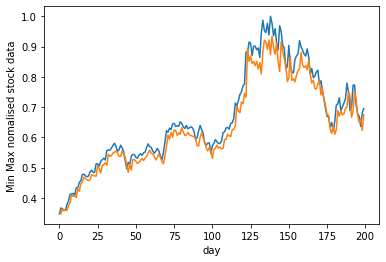

In [369]:

plt.plot(real_labels)
plt.plot(predicted_labels)
plt.xlabel('day')
plt.ylabel('Min Max nomalised stock data')


The test MSE when all the avaiable data is used to generate the test prediction is better with the test MSE being 0.3169 with the testing current method and 0.5565 with the previous. However, this method is very computationally efficent with 200 models that need training. So, for optimising the hyper parameters of the model I will try and find a comprimise of the two testing methods. 

In [370]:
y_unscaled = mm.inverse_transform(real_labels.reshape(-1, 1))
yhat_unscaled = mm.inverse_transform(predicted_labels.reshape(-1,1))

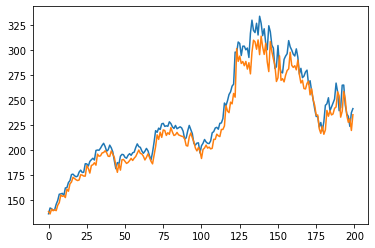

In [371]:
plt.plot(y_unscaled)
plt.plot(yhat_unscaled)

This is an unscaled graphical representation of the predicted lables (orange) and the real labels (blue), which is over a 200 day testing period. It seems that the model tends underpredict upward trends. However, it does well on downward trends. 

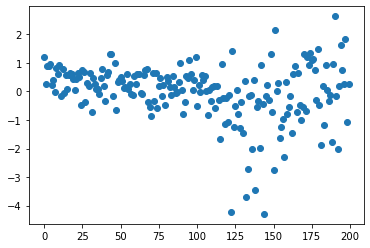

In [372]:
ss_residuals = StandardScaler()
residuals = yhat_unscaled - y_unscaled
standardised_residuals = ss_residuals.fit_transform(residuals)
plt.scatter(range(200), standardised_residuals)

The above shows a plot of the standardised residuals of the model in it's current format. Two observartions can be made. One is that the largest residuals are all as a result of underprediction. The second is that the large residuals (with absoulte value > 2) are found in the final 75 days of the test set. Apon inpection of the plot of real labels the final 75 days seems to have a much higher volitilty than the rest of the dataset. This could be an explanation for the high residuals.

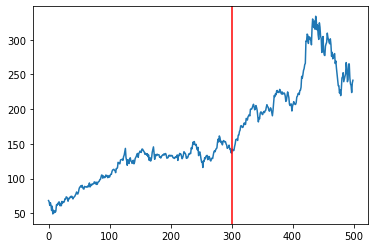

In [396]:

y_tt_unscaled = mm.inverse_transform(y_mm[701:1201])
plt.plot(y_tt_unscaled)
#plt.plot(y_mm)
# y test train unscaled 
plt.axvline(300, color='red')

The graph above shows the labels used soley for training on the left of the red line. On the right we have the labels used for testing / training depending on the labels postion to the cuurent test label.
Interstingly the train samples seem to show a slower less volitile trend as opposed to the test data which shows rapid upward trend. This may explain why the model tends to underpredict as it has not seen such a radid tend in it's training data. This leads me to belive that overtraining may be occuring here as the model is focusing on the pecularties of the train set as opposed to the genral data generating distribution. So, in my next notebook I will investigate the use of regularisation methods to prevent overtraing from occuring. 